In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

This script comprises several distinct functionalities. Kindly review the instructions within each cell prior to execution.

In [ ]:
# Load data with selected time period and selected basins
START_DATE = '1970-01-01'
END_DATE = '2020-12-31'

# Load and filter data
data_path = '/content/drive/MyDrive/MLGP/estreams_dyn_sta_merged_1705b_50year.feather'
df = pd.read_feather(data_path)
df = df[(df['date'] >= START_DATE) & (df['date'] <= END_DATE)]

In [ ]:
# Subset to a fixed number of basins
BASIN_LIMIT = 1000  # number of random basins to select
selected_basins = np.random.choice(df['basin_id'].unique(), BASIN_LIMIT, replace=False)
df = df[df['basin_id'].isin(selected_basins)]

print(df.shape)
df.head()
print(df['basin_id'].nunique())

In [ ]:
# Subset from a single cluster
cluster_df = pd.read_csv('/content/drive/MyDrive/MLGP/cluster_loc.csv')  # update path

# Define which clusters to select from
# selected_clusters = [0, 2, 4]  # change as needed
selected_clusters = [5]  # change as needed

# Get list of basin_ids in those clusters
cluster_basins = cluster_df[cluster_df['KMeans Cluster'].isin(selected_clusters)]['Basin ID'].unique()

# Filter the main dataset to only those basins
df = df[df['basin_id'].isin(cluster_basins)]
print(df['basin_id'].nunique())


In [ ]:
# Subset from multiple clusters
cluster_df = pd.read_csv('/content/drive/MyDrive/MLGP/cluster_loc.csv')  # update path
selected_clusters = [1,2,3,4,5]  # clusters to select from
BASIN_LIMIT_PER_CLUSTER = 98
cluster_basins_limited = []

# Get only basins that exist in final df
available_basins = set(df['basin_id'].unique())

for c in selected_clusters:
    # Basins in this cluster
    basins_in_cluster = cluster_df[cluster_df['KMeans Cluster'] == c]['Basin ID'].unique()

    # Restrict to those available in df
    basins_available = list(set(basins_in_cluster) & available_basins)

    # Sample only if we have enough basins
    n = min(len(basins_available), BASIN_LIMIT_PER_CLUSTER)
    if n > 0:
        sampled = np.random.choice(basins_available, n, replace=False)
        cluster_basins_limited.extend(sampled)

# Filter df to selected basins
df = df[df['basin_id'].isin(cluster_basins_limited)]

# Print number of unique basins
print(f"Selected basins: {len(cluster_basins_limited)}")
print(f"Number of basins in df: {df['basin_id'].nunique()}")


In [ ]:
# Standardizing the predictiors
# Define updated feature lists
dynamic_features = ['p_mean', 'pet_mean', 't_mean', 't_min', 't_max',
                    'sp_mean', 'rh_mean', 'swr_mean']
static_features = ['ele_mt_mean', 'slp_dg_mean', 'strm_dens', 'flat_area_fra',
                   'steep_area_fra', 'soil_tawc_mean', 'soil_bd_mean',
                   'soil_fra_sand_mean', 'soil_fra_clay_mean', 'root_dep_mean',
                   'bedrk_dep', 'dam_num', 'res_num', 'lakes_tot_area',
                   'ndvi_mean', 'lai_mean', 'area_estre']


# Apply log transform to specified static variables before standardizing
log_transform_cols = ['area_estre', 'lakes_tot_area', 'dam_num', 'res_num', 'lai_mean',
                      'ele_mt_mean', 'steep_area_fra', 'slp_dg_mean', 'bedrk_dep']
df[log_transform_cols] = df[log_transform_cols].applymap(lambda x: np.log1p(x))

# Standardize dynamic and static features globally
scaler_dyn = StandardScaler()
df[dynamic_features] = scaler_dyn.fit_transform(df[dynamic_features])

scaler_stat = StandardScaler()
df[static_features] = scaler_stat.fit_transform(df[static_features])



<ipython-input-7-e5ed054176d3>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[log_transform_cols] = df[log_transform_cols].applymap(lambda x: np.log1p(x))


In [ ]:
#%% Adding cyclical features for seasonality
df['doy_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear / 365.25)
df['doy_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear / 365.25)


In [ ]:
# Standardize streamflow per basin
df['streamflow_std'] = np.nan
for basin, group in df.groupby('basin_id'):
    mean = group['streamflow'].mean()
    std = group['streamflow'].std()
    df.loc[group.index, 'streamflow_std'] = (group['streamflow'] - mean) / std

sf_stats = df.groupby('basin_id')['streamflow'].agg(['mean','std']).rename(columns={'mean':'sf_mean','std':'sf_std'})
print(sf_stats)

In [ ]:
# Standardize streamflow Globally
scaler = StandardScaler()
df['streamflow_std'] = scaler.fit_transform(df[['streamflow']])

In [ ]:
# For future use
# # 3. Define features & window
# WINDOW = 24  # use past 12 weeks
# DYN_FEATURES = ['p_mean','t_mean','t_min','t_max']
# STATIC_FEATURES = ['ele_mt_mean','slp_dg_mean','strm_dens','flat_area_fra','steep_area_fra',
#                    'soil_tawc_mean','soil_bd_mean','soil_fra_sand_mean','soil_fra_clay_mean','root_dep_mean',
#                    'bedrk_dep','dam_num','res_num','lakes_tot_area','ndvi_mean','lai_mean','area_estre']


In [ ]:
#. Define features & window
WINDOW = 36  # use past 12 weeks
#DYN_FEATURES = ['p_mean','t_min','t_max', 'doy_sin', 'doy_cos']
DYN_FEATURES = ['p_mean','t_min','t_max', 'doy_sin', 'doy_cos']
STATIC_FEATURES = ['ele_mt_mean','slp_dg_mean','strm_dens',
                   'root_dep_mean',
                   'bedrk_dep','ndvi_mean','lai_mean','area_estre']


In [ ]:
#Creating Sequences
seqs_dyn, seqs_stat, ys, basin_ids = [], [], [], []

for basin, g in df.groupby('basin_id'):
    g = g.sort_values('date').reset_index(drop=True)
    for i in range(len(g) - WINDOW):
        Xdyn = g.loc[i:i+WINDOW-1, DYN_FEATURES].values.astype(np.float32)
        Xstat = g.loc[i+WINDOW, STATIC_FEATURES].values.astype(np.float32)
        y_std  = g.loc[i+WINDOW, 'streamflow_std']
        seqs_dyn.append(Xdyn)
        seqs_stat.append(Xstat)
        ys.append(y_std)
        basin_ids.append(basin)

X_dyn = np.stack(seqs_dyn)          # shape (N, WINDOW, D)
X_stat = np.stack(seqs_stat)        # shape (N, S)
y = np.array(ys)                    # shape (N,)
basin_ids = np.array(basin_ids)


In [ ]:
# Saving the sequence for future use
# np.savez_compressed("/content/drive/MyDrive/LSTM_sequences_multi_basin.npz",
#                     X_dyn=X_dyn,
#                     X_stat=X_stat,
#                     y=y,
#                     basin_ids=basin_ids)
# Load it later
# data = np.load("/content/drive/MyDrive/LSTM_sequences_multi_basin.npz")
# X_dyn = data["X_dyn"]
# X_stat = data["X_stat"]
# y = data["y"]
# basin_ids = data["basin_ids"]


In [ ]:
# #  Build sequences efficiently if memory usage is high and it crashes

# from math import floor

# WINDOW = 4
# total_seqs = sum(floor(len(g) - WINDOW) for _, g in df.groupby('basin_id') if len(g) > WINDOW)

# # Get feature sizes
# dyn_dim = len(DYN_FEATURES)
# stat_dim = len(STATIC_FEATURES)

# # Preallocate arrays
# X_dyn = np.zeros((total_seqs, WINDOW, dyn_dim), dtype=np.float32)
# X_stat = np.zeros((total_seqs, stat_dim), dtype=np.float32)
# y = np.zeros((total_seqs,), dtype=np.float32)
# basin_ids = []

# idx = 0
# for basin, g in df.groupby('basin_id'):
#     g = g.sort_values('date').reset_index(drop=True)
#     for i in range(len(g) - WINDOW):
#         X_dyn[idx] = g.loc[i:i+WINDOW-1, DYN_FEATURES].values
#         X_stat[idx] = g.loc[i+WINDOW, STATIC_FEATURES].values
#         y[idx] = g.loc[i+WINDOW, 'streamflow_std']
#         basin_ids.append(basin)
#         idx += 1



In [ ]:
# 6. Train/test/validation split by date index

# extract dates from sequences (the prediction date)
dates = []
idx = []
offset = WINDOW
for basin, g in df.groupby('basin_id'):
    n = len(g)
    dates.extend(g['date'].iloc[offset:].tolist())
dates = np.array(dates)

# Define cutoffs
val_cutoff = pd.to_datetime("2005-12-31")   # end of training window
test_cutoff = pd.to_datetime("2010-12-31")  # start of test window

# Masks
train_mask = dates <= val_cutoff
val_mask   = (dates > val_cutoff) & (dates <= test_cutoff)
test_mask  = dates > test_cutoff

# Apply masks
X_dyn_train = X_dyn[train_mask].astype(np.float32)
X_stat_train = X_stat[train_mask].astype(np.float32)
y_train = y[train_mask].astype(np.float32)
b_train = basin_ids[train_mask]  # typically remains integer or string (no need to convert)

X_dyn_val = X_dyn[val_mask].astype(np.float32)
X_stat_val = X_stat[val_mask].astype(np.float32)
y_val = y[val_mask].astype(np.float32)
b_val = basin_ids[val_mask]

X_dyn_test = X_dyn[test_mask].astype(np.float32)
X_stat_test = X_stat[test_mask].astype(np.float32)
y_test = y[test_mask].astype(np.float32)
b_test = basin_ids[test_mask]



In [ ]:
# 7. Build the model
# Sequence input
seq_in = Input(shape=(WINDOW, len(DYN_FEATURES)), name='seq_input')
#x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(seq_in)
x = LSTM(96, dropout=0.2)(seq_in)

# Static input
stat_in = Input(shape=(len(STATIC_FEATURES),), name='static_input')
s = Dense(32, activation='relu')(stat_in)

# Merge
m = concatenate([x, s])
m = Dense(32, activation='relu')(m)
m = Dropout(0.2)(m)
out = Dense(1, activation='linear', name='out')(m)

model = Model([seq_in, stat_in], out)
from tensorflow.keras.optimizers import Adam

# Define Adam with custom learning rate
learning_rate = 0.0001  # or try 1e-3, 5e-4, 1e-4
optimizer = Adam(learning_rate=learning_rate)

# Compile model with custom optimizer
model.compile(optimizer=optimizer, loss='mae')


In [ ]:
# 8. Train with EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    [X_dyn_train, X_stat_train], y_train,
    validation_data=([X_dyn_val, X_stat_val], y_val),
    epochs=50,
    batch_size=256,
    callbacks=[es],
    verbose=2
)


In [ ]:
# 9. Predict & inverse-transform for per basin normalization
y_pred_std = model.predict([X_dyn_test, X_stat_test]).flatten()

# inverse transform each sample
sf_mean = sf_stats['sf_mean'].to_dict()
sf_std  = sf_stats['sf_std'].to_dict()
y_pred_raw = np.array([y_pred_std[i]*sf_std[b_test[i]] + sf_mean[b_test[i]]
                       for i in range(len(y_pred_std))])
y_true_raw = np.array([y_test[i]*sf_std[b_test[i]] + sf_mean[b_test[i]]
                       for i in range(len(y_test))])


14077/14077 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step


In [ ]:
# 9. Predict & inverse-transform for global normalization
y_pred_std = model.predict([X_dyn_test, X_stat_test]).flatten()
y_pred_raw = scaler.inverse_transform(y_pred_std.reshape(-1, 1)).flatten()
y_true_raw = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


5741/5741 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step


In [ ]:
#Observe the losses
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_validation_lossunc_mb_stsc.png", dpi=300)
plt.show()



In [ ]:
# 10. Evaluation
rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
# Nash-Sutcliffe Efficiency
nse = 1 - np.sum((y_true_raw - y_pred_raw)**2)/np.sum((y_true_raw - np.mean(y_true_raw))**2)

print(f"Test RMSE: {rmse:.3f}, NSE: {nse:.3f}")
def kling_gupta_efficiency(obs, sim):
    obs = np.array(obs)
    sim = np.array(sim)

    r = np.corrcoef(obs, sim)[0, 1]  # Pearson correlation
    alpha = np.std(sim) / np.std(obs)  # Variability ratio
    beta = np.mean(sim) / np.mean(obs)  # Bias ratio

    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge
kge = kling_gupta_efficiency(y_true_raw, y_pred_raw)
print(f"Test RMSE: {rmse:.3f}, NSE: {nse:.3f}, KGE: {kge:.3f}")


In [ ]:
#Per basin Evaluation
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

basin_scores = []

for basin in np.unique(b_test):
    idxs = np.where(b_test == basin)[0]
    obs = y_true_raw[idxs]
    pred = y_pred_raw[idxs]
    nse_b = 1 - np.sum((obs - pred)**2) / np.sum((obs - np.mean(obs))**2)
    kge_b = kling_gupta_efficiency(obs, pred)
    basin_scores.append({
        'basin_id': basin,
        'NSE': nse_b,
        'KGE': kge_b
    })
scores_df = pd.DataFrame(basin_scores)
scores_df.to_csv('basin_scores_unc_mb_stsc.csv', index=False)

In [ ]:
# Reconstruct prediction dates for test set
dates_all = []

for basin, g in df.groupby('basin_id'):
    g = g.sort_values('date').reset_index(drop=True)
    dates_all.extend(g['date'].iloc[WINDOW:].tolist())

dates_all = pd.to_datetime(dates_all)
dates_test = dates_all[test_mask]


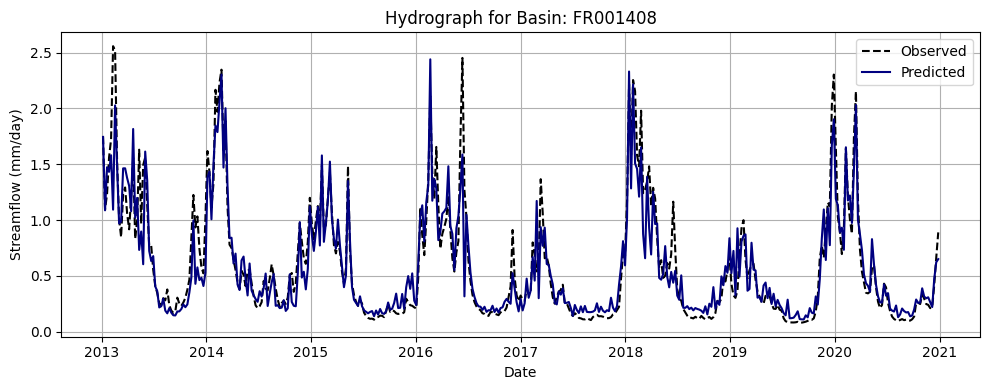

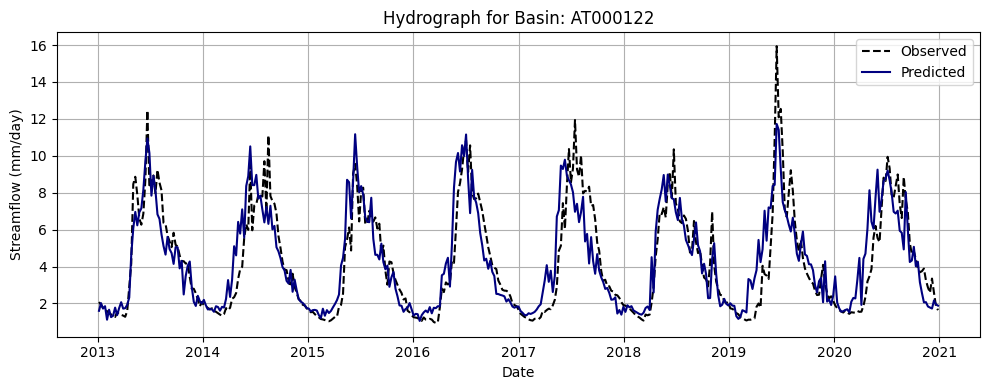

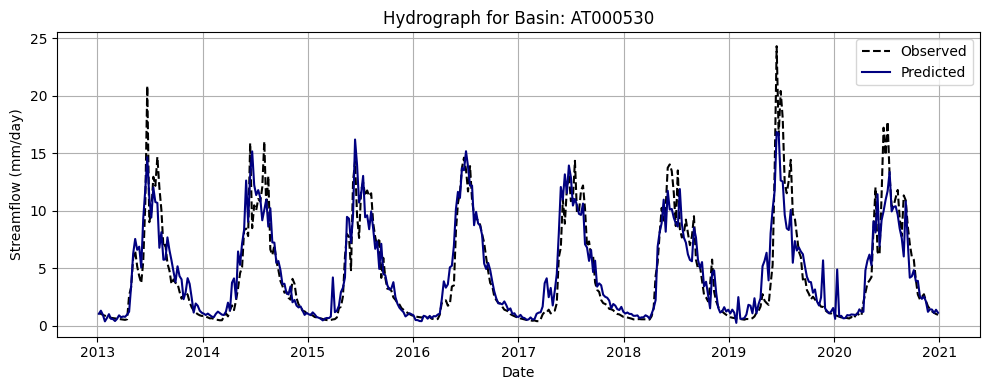

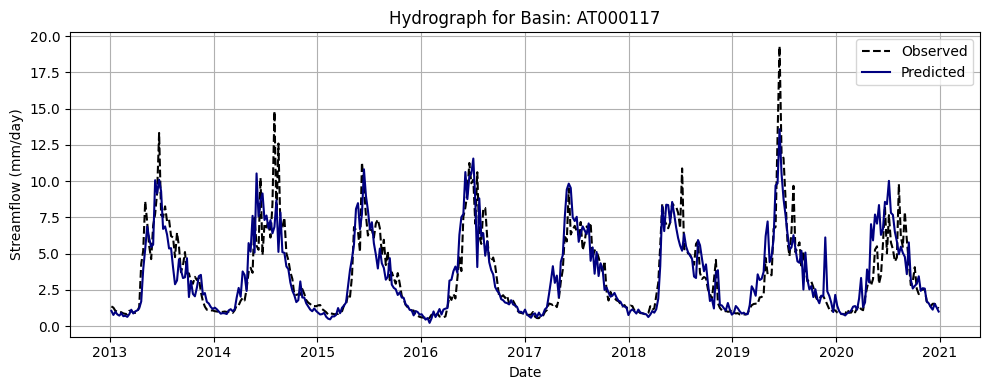

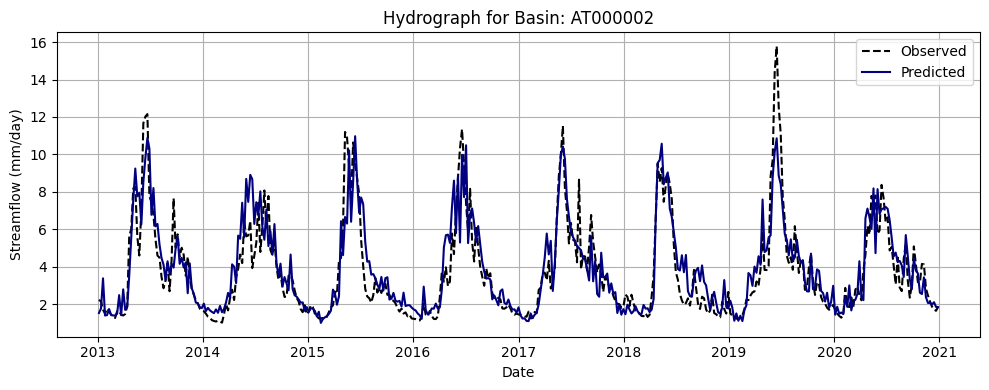

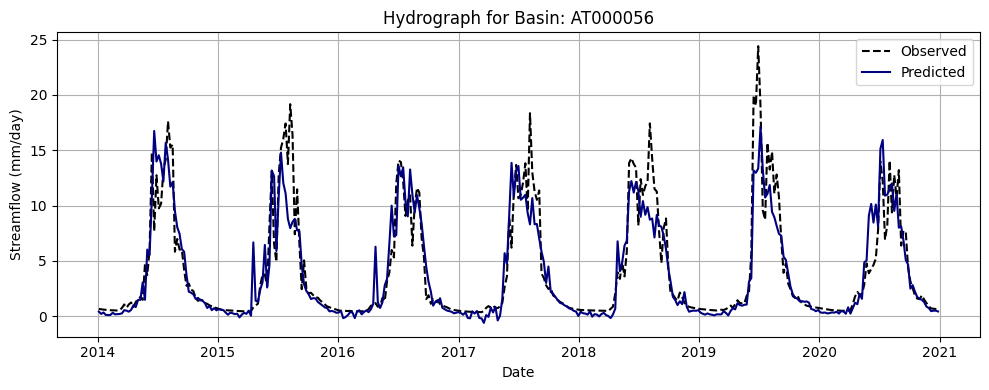

In [ ]:
#Plotting Hydrographs
import matplotlib.pyplot as plt
import os

os.makedirs("hydrographs", exist_ok=True)

# Choose top 3 basins based on KGE
top_basins = scores_df.sort_values(by='KGE', ascending=False).head(6)['basin_id'].values

for basin in top_basins:
    idxs = np.where(b_test == basin)[0]
    plt.figure(figsize=(10, 4))
    plt.plot(dates_test[idxs], y_true_raw[idxs], label='Observed', color='black', linestyle='--')
    plt.plot(dates_test[idxs], y_pred_raw[idxs], label='Predicted', color='navy')
    plt.xlabel('Date')
    plt.ylabel('Streamflow (mm/day)')
    plt.title(f"Hydrograph for Basin: {basin}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    filename = f"hydrographs/hydrograph_laredata_01_{basin}.png"
    plt.savefig(filename, dpi=300)

In [ ]:
model.save('largedataset_pbsc_03.keras')
# To reload later:
# from tensorflow.keras.models import load_model
# model = load_model('final_model.h5')


The following portion is for tuning the hyper-parameters

In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    # Sequence Input
    seq_input = Input(shape=(WINDOW, len(DYN_FEATURES)), name='seq_input')
    x = LSTM(
        units=hp.Int("lstm_units", min_value=32, max_value=128, step=32),
        dropout=hp.Float("lstm_dropout", 0.1, 0.5, step=0.1),
        recurrent_dropout=hp.Float("recurrent_dropout", 0.0, 0.3, step=0.1)
    )(seq_input)

    # Static Input
    static_input = Input(shape=(len(STATIC_FEATURES),), name='static_input')
    s = Dense(
        units=hp.Int("static_dense_units", min_value=16, max_value=64, step=16),
        activation='relu'
    )(static_input)

    # Merge
    merged = concatenate([x, s])
    merged = Dense(hp.Int("merged_units", 32, 128, step=32), activation='relu')(merged)
    merged = Dropout(hp.Float("merged_dropout", 0.1, 0.5, step=0.1))(merged)
    out = Dense(1, activation='linear')(merged)

    model = Model(inputs=[seq_input, static_input], outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-4, 5e-4, 1e-3])),
        loss='mae'
    )
    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory="tuner_results",
    project_name="multi_basin_lstm"
)


In [ ]:
tuner.search([X_dyn_train, X_stat_train], y_train,
             validation_data=([X_dyn_val, X_stat_val], y_val),
             epochs=30, batch_size=32)
